# Raster matricial dos tipos de uso

In [59]:
import geopandas as gpd
import pandas as pd
import rasterio

## Carregando e pre-processando os dados de IPTU

In [60]:
# Padrões de nomenclatura de usos

usos = {
    "apartamento em condomínio":"apartamento",
    "cortiço (habitação coletiva subnormal)":"cortiço",
    "escritório/consultório em condomínio (unidade autônoma)":"escritório ou consultório",
    "loja em edifício em condomínio (unidade autônoma)":"loja em edifício em condomínio",
    "residência coletiva, exclusive cortiço (mais de uma residência no lote)":"residência coletiva (mais de uma residência no lote), exclusive cortiço",
    "posto de serviço (combustíveis)":"posto de serviço",
    "estacionamento e garagem, não em condomínio":"garagem (exclusive em prédio em condomínio)",
    "garagem (unidade autônoma) de prédio de garagens":"garagem, em prédio de garagens",
    "garagem (unidade autônoma) em edifício em condomínio de escritórios, consultórios ou misto":"garagem em edifício de escritórios, consultórios ou misto",
    "garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial":"garagem em edifício de uso exclusivamente residencial",
    "outras edificações de uso coletivo, com utilização múltipla":"outras edificações do tipo (uso coletivo), com utilização múltipla",
    "outras edificações de uso comercial, com utilização múltipla":"outras edificações do tipo (uso comércio), com utilização múltipla",
    "outras edificações de uso de serviço, com utilização múltipla":"outras edificações do tipo (uso serviço), com utilização múltipla",
    "outras edificações de uso especial, com utilização múltipla":"outras edificações do tipo (uso especial), com utilização múltipla",
    "prédio com uso exclusivamente residencial, não em condomínio":"prédio de apartamento, não em condomínio, de uso exclusivamente residencial",
    "prédio com uso misto, predominância de uso não residencial, não em condomínio":"prédio de escritório, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios) com ou sem loja (predominância comercial)",
    "prédio com uso misto, predominância de uso residencial, não em condomínio":"prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)",
    "prédio de escritório ou consultório, com ou sem lojas, não em condomínio":"prédio de escritório ou consultório, não em condomínio, com ou sem lojas",
    "flat de uso comercial (semelhante a hotel)":"flat, não residencial",
    "flat residencial em condomínio":"flat, residencial"
}

In [61]:
df_iptu = pd.read_csv('IPTU/IPTU_2020.zip',\
             compression='zip',\
             encoding='iso-8859-9',\
             sep=';',\
             decimal=',',\
             error_bad_lines=False)

In [62]:
# Obter o SQ (Setor e Quadra)
df_iptu['setor'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[0:3]
df_iptu['quadra'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[3:6]

# Calculando chave 'SQ'
df_iptu['sq'] = \
df_iptu['setor'] + df_iptu['quadra']

# Normalizando o lote condominial
df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] != '00', 'lote'] = '0000'
df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'lote'] = \
df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'NUMERO DO CONTRIBUINTE'].str[6:10]

# Individualizando a testada e pavimentos por lote (SQLC)
df_iptu['sqlc'] = df_iptu['setor'] + \
df_iptu['quadra'] + df_iptu['lote'] + \
df_iptu['NUMERO DO CONDOMINIO'].str[0:2]

df_iptu['AREA CONSTRUIDA'] = pd.to_numeric(df_iptu['AREA CONSTRUIDA'], errors ='coerce')
df_iptu['AREA OCUPADA'] = pd.to_numeric(df_iptu['AREA OCUPADA'], errors ='coerce')
df_iptu['AREA DO TERRENO'] = pd.to_numeric(df_iptu['AREA DO TERRENO'], errors ='coerce')
df_iptu['FRACAO IDEAL'] = pd.to_numeric(df_iptu['FRACAO IDEAL'], errors ='coerce')
df_iptu['QUANTIDADE DE PAVIMENTOS'] = pd.to_numeric(df_iptu['QUANTIDADE DE PAVIMENTOS'], errors ='coerce')
df_iptu['TESTADA PARA CALCULO'] = pd.to_numeric(df_iptu['TESTADA PARA CALCULO'], errors ='coerce')

# Adequando variáveis à fração ideal
df_iptu['area_terreno'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA DO TERRENO']
df_iptu['area_ocupada'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA OCUPADA']

# Adequar os usos ao padrão estabelecido
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL']\
            .isin(usos),\
            'TIPO DE USO DO IMOVEL'] = \
df_iptu[df_iptu['TIPO DE USO DO IMOVEL']\
             .isin(usos)]['TIPO DE USO DO IMOVEL']\
.apply(lambda x: usos[x])

## Carregando e pré-processando as quadras

In [63]:
# Carregando geometria das quadras fiscais
gdf_quadras = gpd.GeoDataFrame.from_file(f'zip://GIS/SIRGAS_SHP_quadraMDSF.zip!SIRGAS_SHP_quadraMDSF')

gdf_quadras['sq'] = gdf_quadras.qd_setor + gdf_quadras.qd_fiscal

gdf_quadras = gdf_quadras.loc[gdf_quadras.qd_tipo == 'F'][['sq', 'geometry']].dissolve(by='sq')

gdf_quadras.geometry = gdf_quadras.representative_point()

## Agrupando os tipos de uso

In [64]:
df_iptu.columns

Index(['NUMERO DO CONTRIBUINTE', 'ANO DO EXERCICIO', 'NUMERO DA NL',
       'DATA DO CADASTRAMENTO', 'TIPO DE CONTRIBUINTE 1',
       'CPF/CNPJ DO CONTRIBUINTE 1', 'NOME DO CONTRIBUINTE 1',
       'TIPO DE CONTRIBUINTE 2', 'CPF/CNPJ DO CONTRIBUINTE 2',
       'NOME DO CONTRIBUINTE 2', 'NUMERO DO CONDOMINIO', 'CODLOG DO IMOVEL',
       'NOME DE LOGRADOURO DO IMOVEL', 'NUMERO DO IMOVEL',
       'COMPLEMENTO DO IMOVEL', 'BAIRRO DO IMOVEL', 'REFERENCIA DO IMOVEL',
       'CEP DO IMOVEL', 'QUANTIDADE DE ESQUINAS/FRENTES', 'FRACAO IDEAL',
       'AREA DO TERRENO', 'AREA CONSTRUIDA', 'AREA OCUPADA',
       'VALOR DO M2 DO TERRENO', 'VALOR DO M2 DE CONSTRUCAO',
       'ANO DA CONSTRUCAO CORRIGIDO', 'QUANTIDADE DE PAVIMENTOS',
       'TESTADA PARA CALCULO', 'TIPO DE USO DO IMOVEL',
       'TIPO DE PADRAO DA CONSTRUCAO', 'TIPO DE TERRENO',
       'FATOR DE OBSOLESCENCIA', 'ANO DE INICIO DA VIDA DO CONTRIBUINTE',
       'MES DE INICIO DA VIDA DO CONTRIBUINTE', 'FASE DO CONTRIBUINTE',
       'seto

In [65]:
len(df_iptu)

3498644

In [66]:
df_iptu.loc[:, 'TIPO DE USO DO IMOVEL'] = df_iptu.loc[:, 'TIPO DE USO DO IMOVEL'].str.capitalize()

In [67]:
df_iptu.loc[:, 'TIPO DE USO DO IMOVEL'].value_counts()

Apartamento em condomínio                                                                                                                             1363685
Residência                                                                                                                                            1081450
Residência coletiva, exclusive cortiço (mais de uma residência no lote)                                                                                203816
Garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial                                                                 196802
Escritório/consultório em condomínio (unidade autônoma)                                                                                                138156
Terreno                                                                                                                                                109885
Residência e outro uso (predominância residencial)  

In [68]:
usos_agregados = {
    'Residencial':[
        'Apartamento em condomínio',
        'Apartamento',
        'Residência',
        'Garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial',
        'Garagem em edifício de uso exclusivamente residencial',
        'Residência e outro uso (predominância residencial)',
        'Flat residencial em condomínio',
        'Flat, residencial',
        'Prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)',
        'Prédio de apartamento, não em condomínio, de uso exclusivamente residencial',
        'Prédio com uso exclusivamente residencial, não em condomínio',
        'Prédio com uso misto, predominância de uso residencial, não em condomínio',
        'Cortiço',
        'Cortiço (habitação coletiva subnormal)',
        'Asilo, orfanato, creche, seminário ou convento',
        'Residência coletiva, exclusive cortiço (mais de uma residência no lote)',
        'Residência coletiva (mais de uma residência no lote), exclusive cortiço',
        'Hotel, pensão ou hospedaria'
    ],
    'Comercial e Serviços': [
        'Escritório/consultório em condomínio (unidade autônoma)',
        'Loja',
        'Loja e residência (predominância comercial)',
        'Loja em edifício em condomínio',
        'Escritório ou consultório',
        'Garagem (unidade autônoma) em edifício em condomínio de escritórios, consultórios ou misto',
        'Garagem em edifício de escritórios, consultórios ou misto',
        'Prédio de escritório ou consultório, com ou sem lojas, não em condomínio',
        'Prédio de escritório ou consultório, não em condomínio, com ou sem lojas',
        'Outras edificações do tipo (uso comércio), com utilização múltipla',
        'Outras edificações do tipo (uso serviço), com utilização múltipla',
        'Outras edificações do tipo (uso coletivo), com utilização múltipla',
        'Outras edificações do tipo (uso especial), com utilização múltipla',
        'Flat de uso comercial (semelhante a hotel)',
        'Flat, não residencial',
        'Loja em edifício em condomínio (unidade autônoma)',
        'Outras edificações de uso comercial, com utilização múltipla',
        'Garagem (unidade autônoma) de prédio de garagens',
        'Garagem, em prédio de garagens',
        'Estacionamento e garagem, não em condomínio',
        'Escola',
        'Templo',
        'Outras edificações de uso de serviço, com utilização múltipla',
        'Garagem (exclusive em prédio em condomínio)',
        'Posto de serviço',
        'Posto de serviço (combustíveis)',
        'Hospital, ambulatório, casa de saúde e assemelhados',
        'Outras edificações de uso especial, com utilização múltipla',
        'Cinema, teatro, casa de diversão, clube ou congênere',
        'Clube esportivo',
        'Estação radioemissora, de televisão ou empresa jornalística',
        'Prédio de escritório, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios) com ou sem loja (predominância comercial)',
        'Prédio com uso misto, predominância de uso não residencial, não em condomínio',
        'Outras edificações de uso coletivo, com utilização múltipla'
    ],
    'Terrenos, indústria, galpões e outros':[
        'Terreno',
        'Indústria',
        'Oficina',
        'Armazéns gerais e depósitos'
    ]
}

In [69]:
usos_agregados['Residencial']

['Apartamento em condomínio',
 'Apartamento',
 'Residência',
 'Garagem (unidade autônoma) em edifício em condomínio de uso exclusivamente residencial',
 'Garagem em edifício de uso exclusivamente residencial',
 'Residência e outro uso (predominância residencial)',
 'Flat residencial em condomínio',
 'Flat, residencial',
 'Prédio de apartamento, não em condomínio, de uso misto (apartamentos e escritórios e/ou consultórios), com ou sem loja (predominância residencial)',
 'Prédio de apartamento, não em condomínio, de uso exclusivamente residencial',
 'Prédio com uso exclusivamente residencial, não em condomínio',
 'Prédio com uso misto, predominância de uso residencial, não em condomínio',
 'Cortiço',
 'Cortiço (habitação coletiva subnormal)',
 'Asilo, orfanato, creche, seminário ou convento',
 'Residência coletiva, exclusive cortiço (mais de uma residência no lote)',
 'Residência coletiva (mais de uma residência no lote), exclusive cortiço',
 'Hotel, pensão ou hospedaria']

In [70]:
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados['Residencial']), 
            'AREA CONSTRUIDA'].median()

101.0

In [71]:
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados['Residencial']), 
            'AREA CONSTRUIDA'].mean()

127.20050967662914

<AxesSubplot:>

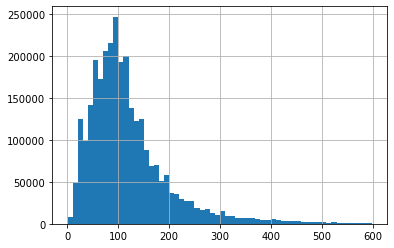

In [72]:
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados['Residencial']) & \
            (df_iptu['AREA CONSTRUIDA'] < 600), 
            'AREA CONSTRUIDA'].hist(bins = 60)

<AxesSubplot:>

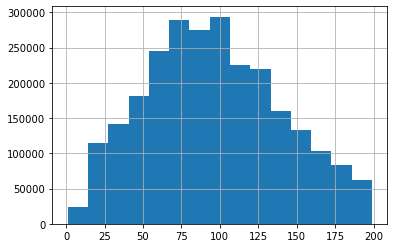

In [73]:
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados['Residencial']) & \
            (df_iptu['AREA CONSTRUIDA'] < 200), 
            'AREA CONSTRUIDA'].hist(bins = 15)

In [74]:
df_iptu_residencial = \
df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados['Residencial']),
           ['TIPO DE USO DO IMOVEL', 'ANO DA CONSTRUCAO CORRIGIDO', 'AREA CONSTRUIDA']]

In [75]:
df_iptu_residencial['A.C. Residencia Horizontal'] = \
df_iptu_residencial.loc[df_iptu_residencial['TIPO DE USO DO IMOVEL'] == 'Residência',
                       'AREA CONSTRUIDA']

In [76]:
df_iptu_residencial['A.C. Apartamento em Condomínio'] = \
df_iptu_residencial.loc[df_iptu_residencial['TIPO DE USO DO IMOVEL'] == 'Apartamento em condomínio',
                       'AREA CONSTRUIDA']

<AxesSubplot:xlabel='ANO DA CONSTRUCAO CORRIGIDO'>

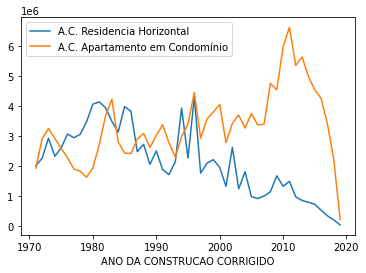

In [77]:
df_iptu_residencial.loc[df_iptu_residencial['ANO DA CONSTRUCAO CORRIGIDO'] > 1970,
                       ['ANO DA CONSTRUCAO CORRIGIDO',
                       'A.C. Residencia Horizontal',
                       'A.C. Apartamento em Condomínio']].\
groupby(['ANO DA CONSTRUCAO CORRIGIDO']).\
sum().plot()

## Agregando por uso agregado e espacializando

In [78]:
usos_agregados.keys()

dict_keys(['Residencial', 'Comercial e Serviços', 'Terrenos, indústria, galpões e outros'])

In [79]:
for k in usos_agregados.keys():
    df_iptu\
    .loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados[k]), \
        'uso_agregado'] = k

In [80]:
df_iptu.uso_agregado.value_counts()

Residencial                              2947359
Comercial e Serviços                      409471
Terrenos, indústria, galpões e outros     141814
Name: uso_agregado, dtype: int64

In [81]:
df_iptu.loc[df_iptu.uso_agregado.isna(), 'TIPO DE USO DO IMOVEL'].value_counts()

Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)

In [82]:
sq_area = df_iptu[['sq', \
                    'AREA CONSTRUIDA']]\
.groupby(['sq'])\
.agg({'AREA CONSTRUIDA': 'sum'})\
.rename(columns = {'AREA CONSTRUIDA': 'area_construida'})

In [83]:
iptu_agg = df_iptu[['sq', \
                    'AREA CONSTRUIDA',
                    'uso_agregado']]\
.groupby(['sq', 'uso_agregado'])\
.agg({'AREA CONSTRUIDA': 'sum'})\
.rename(columns = {'AREA CONSTRUIDA': 'area_construida'})

In [84]:
iptu_agg_qd = iptu_agg.reset_index().merge(sq_area, on='sq', how='left')

In [85]:
iptu_agg_qd = \
iptu_agg_qd.loc[(iptu_agg_qd.area_construida_y != 0) | \
               (iptu_agg_qd.area_construida_x != 0)]

In [86]:
iptu_agg_qd

,sq,uso_agregado,area_construida_x,area_construida_y
0,001003,Comercial e Serviços,22140,29926
1,001003,Residencial,7786,29926
2,001003,"Terrenos, indústria, galpões e outros",0,29926
3,001004,Comercial e Serviços,13305,20715
4,001004,Residencial,5994,20715
...,...,...,...,...
103915,310116,Comercial e Serviços,180,1313
103916,310116,Residencial,1133,1313
103917,310117,Comercial e Serviços,728,22601
103918,310117,Residencial,21873,22601


In [87]:
# Gerando GeoDataFrame
gdf_iptu_agg = gdf_quadras.merge(iptu_agg_qd, on='sq', how='right')

## Gerando Raster com usos agregados

In [88]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import rasterio

In [89]:
resolucao_espacial = 30

In [90]:
limite_municipio = gpd.read_file('GIS/municipio-de-São-Paulo.gpkg')

/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [91]:
x_range = np.arange(limite_municipio.bounds.minx[0],
                    limite_municipio.bounds.maxx[0] + resolucao_espacial,
                    resolucao_espacial)

y_range = np.arange(limite_municipio.bounds.miny[0],
                    limite_municipio.bounds.maxy[0] + resolucao_espacial,
                    resolucao_espacial)

In [92]:
grid_x, grid_y = np.meshgrid(x_range, y_range)

In [93]:
gdf_iptu_agg = gdf_iptu_agg[gdf_iptu_agg.is_valid]

In [94]:
gdf_iptu_agg = gdf_iptu_agg.set_index('sq')

In [95]:
gdf_iptu_agg_res = gdf_iptu_agg.loc[gdf_iptu_agg.uso_agregado == 'Residencial']
gdf_iptu_agg_com = gdf_iptu_agg.loc[gdf_iptu_agg.uso_agregado == 'Comercial e Serviços']
gdf_iptu_agg_outros = gdf_iptu_agg.loc[gdf_iptu_agg.uso_agregado == 'Terrenos, indústria, galpões e outros']

In [96]:
df_iptu_agg_usos = \
pd.concat([gdf_iptu_agg.groupby('sq')['geometry'].first(),
          gdf_iptu_agg_res.loc[:, 'area_construida_x'].rename('Residencial'),
          gdf_iptu_agg_com.loc[:, 'area_construida_x'].rename('Comercial e Serviços'),
          gdf_iptu_agg_outros.loc[:, 'area_construida_x'].rename('Terrenos, indústria, galpões e outros'),
          gdf_iptu_agg.groupby('sq')['area_construida_y'].first().rename('Area Total Construida')],
          axis=1)

In [97]:
df_iptu_agg_usos

,geometry,Residencial,Comercial e Serviços,"Terrenos, indústria, galpões e outros",Area Total Construida
sq,,,,,
001003,POINT (333387.800 7396468.599),7786.0,22140.0,0.0,29926
001004,POINT (333487.097 7396436.735),5994.0,13305.0,1416.0,20715
001005,POINT (333561.571 7396423.397),5431.0,10246.0,1586.0,17263
001006,POINT (333606.259 7396412.473),3137.0,4279.0,270.0,7686
001007,POINT (333670.058 7396400.965),13246.0,12521.0,300.0,26067
...,...,...,...,...,...
310114,POINT (332961.601 7383593.159),5025.0,NaN,NaN,5025
310115,POINT (333248.311 7383543.462),10549.0,211.0,244.0,11004
310116,POINT (332733.661 7383530.821),1133.0,180.0,NaN,1313


In [98]:
points_usos = list(df_iptu_agg_usos.geometry.apply(lambda p: (p.x, p.y)))

# Banda Residencial
values_res = df_iptu_agg_usos['Residencial'] / df_iptu_agg_usos['Area Total Construida']
values_res[np.isnan(values_res)] = 0.

# Banda Comercial
values_com = df_iptu_agg_usos['Comercial e Serviços'] / df_iptu_agg_usos['Area Total Construida']
values_com[np.isnan(values_com)] = 0.

# Banda Outros
values_outros = df_iptu_agg_usos['Terrenos, indústria, galpões e outros'] / df_iptu_agg_usos['Area Total Construida']
values_outros[np.isnan(values_outros)] = 0.

In [99]:
len(points_usos)

44504

In [100]:
# Interpolando no grid

grid_res = griddata(points_usos, values_res, (grid_x, grid_y), method='nearest')
grid_com = griddata(points_usos, values_com, (grid_x, grid_y), method='nearest')
grid_outros = griddata(points_usos, values_outros, (grid_x, grid_y), method='nearest')

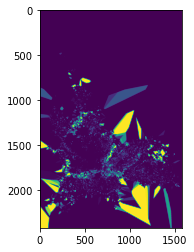

In [101]:
plt.imshow(grid_outros)

## Salvando em arquivos Raster

In [102]:
from rasterio.transform import Affine
from rasterio import mask
from rasterio.crs import CRS

In [103]:
transform = Affine.translation(grid_x[0][0] - resolucao_espacial / 2, 
                               grid_y[0][0] - resolucao_espacial / 2 ) \
                               * Affine.scale(resolucao_espacial, resolucao_espacial)
transform

Affine(30.0, 0.0, 313374.67093572277,
       0.0, 30.0, 7343727.818227606)

In [104]:
raster_crs = CRS.from_epsg(31983)

In [105]:
grid_res = grid_res.astype('float32')
grid_com = grid_com.astype('float32')
grid_outros = grid_outros.astype('float32')

In [106]:
meta = {
    'driver':'GTiff',
    'height':grid_res.shape[0],
    'width':grid_res.shape[1],
    'count':1,
    'nodata':0.,
    'dtype':grid_res.dtype,
    'crs':raster_crs,
    'transform':transform,
}

In [107]:
with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-residencial-2020.TIF', "w", **meta) as dest:
    dest.write(grid_res, 1)


In [108]:
with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-comercial-servicos-2020.TIF', "w", **meta) as dest:
    dest.write(grid_com, 1)

In [109]:
with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-outros-2020.TIF', "w", **meta) as dest:
    dest.write(grid_outros, 1)

In [110]:
# grid_res = np.fl(grid_res * 254)
# grid_com = np.uint8(grid_com * 254)
# grid_outros = np.uint8(grid_outros * 254)

In [111]:
meta = {
    'driver':'GTiff',
    'height':grid_res.shape[0],
    'width':grid_res.shape[1],
    'count':3,
    'nodata':9999.,
    'dtype':grid_res.dtype,
    'crs':raster_crs,
    'transform':transform,
}

In [112]:
with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-usos-color-2020.TIF', "w", **meta) as dest:
    dest.write(grid_res, 1)
    dest.write(grid_com, 2)
    dest.write(grid_outros, 3)

## Gera raster dos tipos de uso para cada ano

In [113]:
from pathlib import Path
import os

In [114]:
for path in Path('IPTU').rglob('*.zip'):
    print(path.name)
    
    # 1. Carregar dados do arquivo
    # OBS.: O IPTU de 2016 está separado por ',' e não por ';'
    if path.name == "IPTU_2016.zip":
        df_iptu = pd.read_csv(f'{path}',\
                     compression='zip',\
                     encoding='iso-8859-9',\
                     sep=',',\
                     decimal=',',\
                     error_bad_lines=False)
    else:
        df_iptu = pd.read_csv(f'{path}',\
                     compression='zip',\
                     encoding='iso-8859-9',\
                     sep=';',\
                     decimal=',',\
                     error_bad_lines=False)
    
    # Obter o SQ (Setor e Quadra)
    df_iptu['setor'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[0:3]
    df_iptu['quadra'] = df_iptu['NUMERO DO CONTRIBUINTE'].str[3:6]

    # Calculando chave 'SQ'
    df_iptu['sq'] = \
    df_iptu['setor'] + df_iptu['quadra']

    # Normalizando o lote condominial
    df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] != '00', 'lote'] = '0000'
    df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'lote'] = \
    df_iptu.loc[df_iptu['NUMERO DO CONDOMINIO'].str[0:2] == '00', 'NUMERO DO CONTRIBUINTE'].str[6:10]

    # Individualizando a testada e pavimentos por lote (SQLC)
    df_iptu['sqlc'] = df_iptu['setor'] + \
    df_iptu['quadra'] + df_iptu['lote'] + \
    df_iptu['NUMERO DO CONDOMINIO'].str[0:2]

    df_iptu['AREA CONSTRUIDA'] = pd.to_numeric(df_iptu['AREA CONSTRUIDA'], errors ='coerce')
    df_iptu['AREA OCUPADA'] = pd.to_numeric(df_iptu['AREA OCUPADA'], errors ='coerce')
    df_iptu['AREA DO TERRENO'] = pd.to_numeric(df_iptu['AREA DO TERRENO'], errors ='coerce')
    df_iptu['FRACAO IDEAL'] = pd.to_numeric(df_iptu['FRACAO IDEAL'], errors ='coerce')
    df_iptu['QUANTIDADE DE PAVIMENTOS'] = pd.to_numeric(df_iptu['QUANTIDADE DE PAVIMENTOS'], errors ='coerce')
    df_iptu['TESTADA PARA CALCULO'] = pd.to_numeric(df_iptu['TESTADA PARA CALCULO'], errors ='coerce')

    # Adequando variáveis à fração ideal
    df_iptu['area_terreno'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA DO TERRENO']
    df_iptu['area_ocupada'] = df_iptu['FRACAO IDEAL'] * df_iptu['AREA OCUPADA']
    
    # Paadronizando tipo de uso com a primeira letra em maíusculo
    df_iptu.loc[:, 'TIPO DE USO DO IMOVEL'] = df_iptu.loc[:, 'TIPO DE USO DO IMOVEL'].str.capitalize()

    # Adequar os usos ao padrão estabelecido
    df_iptu.loc[df_iptu['TIPO DE USO DO IMOVEL']\
                .isin(usos),\
                'TIPO DE USO DO IMOVEL'] = \
    df_iptu[df_iptu['TIPO DE USO DO IMOVEL']\
                 .isin(usos)]['TIPO DE USO DO IMOVEL']\
    .apply(lambda x: usos[x])
    
    for k in usos_agregados.keys():
        df_iptu\
        .loc[df_iptu['TIPO DE USO DO IMOVEL'].isin(usos_agregados[k]), \
            'uso_agregado'] = k
    
    # Auditando os tipos de uso
    print(df_iptu.loc[df_iptu.uso_agregado.isna(), 'TIPO DE USO DO IMOVEL'].value_counts())
    
    sq_area = df_iptu[['sq', \
                       'AREA CONSTRUIDA']]\
        .groupby(['sq'])\
        .agg({'AREA CONSTRUIDA': 'sum'})\
        .rename(columns = {'AREA CONSTRUIDA': 'area_construida'})
    
    iptu_agg = df_iptu[['sq', \
                        'AREA CONSTRUIDA',
                        'uso_agregado']]\
    .groupby(['sq', 'uso_agregado'])\
    .agg({'AREA CONSTRUIDA': 'sum'})\
    .rename(columns = {'AREA CONSTRUIDA': 'area_construida'})
    
    iptu_agg_qd = iptu_agg.reset_index().merge(sq_area, on='sq', how='left')
    
    iptu_agg_qd = \
    iptu_agg_qd.loc[(iptu_agg_qd.area_construida_y != 0) | \
                   (iptu_agg_qd.area_construida_x != 0)]
    
    # Gerando GeoDataFrame
    gdf_iptu_agg = gdf_quadras.merge(iptu_agg_qd, on='sq', how='right')
    
    gdf_iptu_agg = gdf_iptu_agg[gdf_iptu_agg.is_valid]
    
    gdf_iptu_agg = gdf_iptu_agg.set_index('sq')
    
    gdf_iptu_agg_res = gdf_iptu_agg.loc[gdf_iptu_agg.uso_agregado == 'Residencial']
    gdf_iptu_agg_com = gdf_iptu_agg.loc[gdf_iptu_agg.uso_agregado == 'Comercial e Serviços']
    gdf_iptu_agg_outros = gdf_iptu_agg.loc[gdf_iptu_agg.uso_agregado == 'Terrenos, indústria, galpões e outros']
    
    df_iptu_agg_usos = \
    pd.concat([gdf_iptu_agg.groupby('sq')['geometry'].first(),
              gdf_iptu_agg_res.loc[:, 'area_construida_x'].rename('Residencial'),
              gdf_iptu_agg_com.loc[:, 'area_construida_x'].rename('Comercial e Serviços'),
              gdf_iptu_agg_outros.loc[:, 'area_construida_x'].rename('Terrenos, indústria, galpões e outros'),
              gdf_iptu_agg.groupby('sq')['area_construida_y'].first().rename('Area Total Construida')],
              axis=1)
    
    points_usos = list(df_iptu_agg_usos.geometry.apply(lambda p: (p.x, p.y)))

    # Banda Residencial
    values_res = df_iptu_agg_usos['Residencial'] / df_iptu_agg_usos['Area Total Construida']
    values_res[np.isnan(values_res)] = 0.

    # Banda Comercial
    values_com = df_iptu_agg_usos['Comercial e Serviços'] / df_iptu_agg_usos['Area Total Construida']
    values_com[np.isnan(values_com)] = 0.

    # Banda Outros
    values_outros = df_iptu_agg_usos['Terrenos, indústria, galpões e outros'] / df_iptu_agg_usos['Area Total Construida']
    values_outros[np.isnan(values_outros)] = 0.
    
    grid_x, grid_y = np.meshgrid(x_range, y_range)
    
    # Interpolando no grid
    grid_res = griddata(points_usos, values_res, (grid_x, grid_y), method='nearest')
    grid_com = griddata(points_usos, values_com, (grid_x, grid_y), method='nearest')
    grid_outros = griddata(points_usos, values_outros, (grid_x, grid_y), method='nearest')
    
    grid_res = grid_res.astype('float32')
    grid_com = grid_com.astype('float32')
    grid_outros = grid_outros.astype('float32')
    
    meta = {
        'driver':'GTiff',
        'height':grid_res.shape[0],
        'width':grid_res.shape[1],
        'count':1,
        'nodata':0.,
        'dtype':grid_res.dtype,
        'crs':raster_crs,
        'transform':transform,
    }
    
    # Gravando Residencial
    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-residencial-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(grid_res, 1)
        
    result_dataset = rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-residencial-{path.name[-8:-4]}.TIF')

    out_image_crop, out_transform_crop = \
    mask.mask(result_dataset, limite_municipio.geometry, crop=True, invert=False)

    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-residencial-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(out_image_crop)

    # Gravando Comercial-Servicos
    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-comercial-servicos-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(grid_com, 1)
        
    result_dataset = rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-comercial-servicos-{path.name[-8:-4]}.TIF')

    out_image_crop, out_transform_crop = \
    mask.mask(result_dataset, limite_municipio.geometry, crop=True, invert=False)

    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-comercial-servicos-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(out_image_crop)
    
    # Gravando outros usos
    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-outros-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(grid_outros, 1)
        
    result_dataset = rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-residencial-{path.name[-8:-4]}.TIF')

    out_image_crop, out_transform_crop = \
    mask.mask(result_dataset, limite_municipio.geometry, crop=True, invert=False)

    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-uso-residencial-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(out_image_crop)
        
    meta = {
        'driver':'GTiff',
        'height':grid_res.shape[0],
        'width':grid_res.shape[1],
        'count':3,
        'nodata':9999,
        'dtype':grid_res.dtype,
        'crs':raster_crs,
        'transform':transform,
    }
    
    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-todos-usos-color-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(grid_res, 1)
        dest.write(grid_com, 2)
        dest.write(grid_outros, 3)
        
    result_dataset = rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-todos-usos-color-{path.name[-8:-4]}.TIF')

    out_image_crop, out_transform_crop = \
    mask.mask(result_dataset, limite_municipio.geometry, crop=True, invert=False)

    with rasterio.open(f'resultados/tipos_de_uso/IPTU-proporcao-todos-usos-color-{path.name[-8:-4]}.TIF', "w", **meta) as dest:
        dest.write(out_image_crop)

IPTU_2010.zip


b'Skipping line 2445507: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_1996.zip


/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Residência vertical - padrão c    1
Name: TIPO DE USO DO IMOVEL, dtype: int64
IPTU_2007.zip


b'Skipping line 2417712: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2013.zip


b'Skipping line 2560170: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Residência horizontal - padrão b    5
Name: TIPO DE USO DO IMOVEL, dtype: int64
IPTU_2004.zip


b'Skipping line 2325266: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2005.zip


b'Skipping line 2355090: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_1995.zip


/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Residência vertical - padrão c    1
Name: TIPO DE USO DO IMOVEL, dtype: int64
IPTU_1998.zip


b'Skipping line 2096075: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2018.zip
Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2001.zip


b'Skipping line 2211865: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2017.zip
Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2015.zip


b'Skipping line 2651001: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Residência horizontal - padrão b    5
Name: TIPO DE USO DO IMOVEL, dtype: int64
IPTU_2006.zip


b'Skipping line 2381472: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2009.zip


b'Skipping line 2471701: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2014.zip


b'Skipping line 2606431: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Residência horizontal - padrão b    5
Name: TIPO DE USO DO IMOVEL, dtype: int64
IPTU_2011.zip


b'Skipping line 2484471: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2000.zip


b'Skipping line 2156584: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2019.zip
Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_1997.zip


/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Residência vertical - padrão c    1
Name: TIPO DE USO DO IMOVEL, dtype: int64
IPTU_2016.zip
Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2002.zip


b'Skipping line 2247445: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_1999.zip


b'Skipping line 2121196: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2020.zip
Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2008.zip


b'Skipping line 2440049: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2003.zip


b'Skipping line 2288886: expected 35 fields, saw 43\n'


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
IPTU_2012.zip


b'Skipping line 2526350: expected 35 fields, saw 43\n'
/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Series([], Name: TIPO DE USO DO IMOVEL, dtype: int64)
